In [1]:
#import Pigments 
#from Pigments import lB, χ, κ
#from Pigments import *
import Pigments_ver2 
from Pigments_ver2 import *
import scipy
from scipy.optimize import minimize,shgo,curve_fit,Bounds,root_scalar
import matplotlib.pyplot as plt

#Import mathematica table
import h5py
def import_hdf5(filename):
    f = h5py.File(filename, 'r')
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    return np.array(data)

In [2]:
#To define model
model=Pigments_ver2.macro_parameters(N=100,λ0=4.8/100)
fp=fmacromix(N=model.N)
fw=fmolmix
fwp=fχ
fdd=fdipole_dipole
λAS=λ(λ0=model.λ0)
fAS=fassociation(N=model.N)

In [23]:
def ftotal(**kwarg):
    return ( fp(φ=kwarg["φ"])
            +fw(φ0=1-kwarg["φ"])
            +fwp(χ=kwarg["χ"])(φ=kwarg["φ"], φ0=1-kwarg["φ"])
           )

#a=4*π*np.power(0.7,2)/18*4/9
#chi0=0.5+1/np.sqrt(model.N)+1/(2*model.N)
#chi=lambda T:a+chi0-3.3*a*300/T
χc=0.5+1/np.sqrt(model.N)+1/(2*model.N)
chi=lambda T:χc*280/T

def ojective_saltfree(phase_vector,arg_vector):
    r,φ_one=phase_vector
    φ_exp,T = arg_vector
    φ_two=abs((φ_exp - r*φ_one)/(1-r))
    if 1>r>0 and 1>φ_one>0 and 1>φ_two>0 and φ_exp>=r*φ_one:
        φ_two=(φ_exp - r*φ_one)/(1-r)
        value=r* ftotal(φ=φ_one,χ=chi(T)) + (1-r) * ftotal(φ=φ_two,χ=chi(T))
    else:
        value=np.inf
    return value

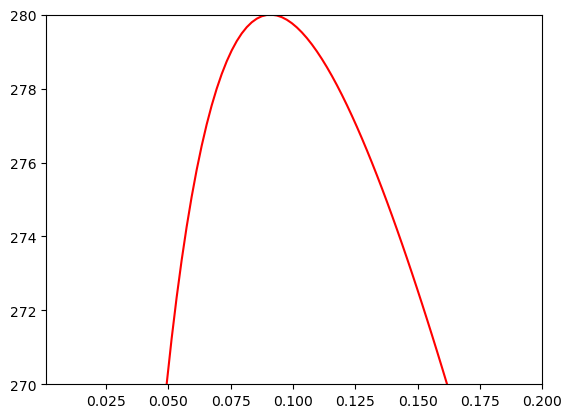

In [27]:
#Spinodal Curve
Phi = np.linspace(0.001, 0.2, num=100)
T = np.linspace(270, 280, num=500)
Z=[[Dfφφ(ftotal,φ=x,χ=chi(y)) for x in Phi] for y in T]
phi,t=np.meshgrid(Phi,T)
cs=plt.contour(phi, t, Z,[0],colors='red')
phi_s = cs.collections[0].get_paths()[0].vertices[:,0]
t_s = cs.collections[0].get_paths()[0].vertices[:,1]

#np.save(f"phi_t_LCST_Spinodal.npy",[phi_s,t_s])
#plt.close()

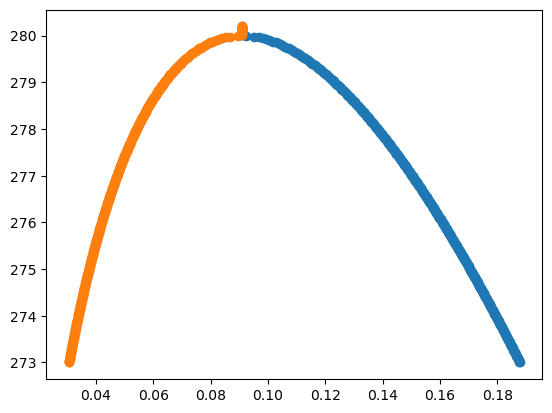

In [25]:
#Binodal Curve

#Using spinodal curve too narrow the range of binodal curve
#x,y=np.load("phi_t_LCST_Spinodal.npy",allow_pickle=True)
#medium=(x+x[::-1])/2
y=np.linspace(273, 282, num=500)

binodal=list([])
for i in range(0,400):#range(0,np.argmin(y)-3):
        #phi_0=medium[i]
        phi_0=1/(np.sqrt(model.N)+1)
        T=y[i]
        res = minimize(ojective_saltfree, [0.3, 0.2],args=([phi_0,T]), method='nelder-mead',
                       options={'xatol': 1e-8, 'disp': False})
        if res.success == True:
            r=res.x[0]
            phi_one=res.x[1]
            phi_two=(phi_0 - r*phi_one)/(1-r)
            binodal.append([np.max([phi_one,phi_two]),np.min([phi_one,phi_two]),T])
            
#Inspection of data
plt.scatter(np.array(binodal)[:,0],np.array(binodal)[:,2])
plt.scatter(np.array(binodal)[:,1],np.array(binodal)[:,2])

#np.save(f"rich_poor_t_LCST_Binodal.npy",[np.array(binodal)[:,0],np.array(binodal)[:,1],np.array(binodal)[:,2]]);
#np.save(f"rich_poor_t_UCST_Binodal_Tc_280.npy",[np.array(binodal)[:,0],np.array(binodal)[:,1],np.array(binodal)[:,2]]); 

In [9]:
def ftotal(**kwarg):
    return ( fp(φ=kwarg["φ"])
            +fw(φ0=1-kwarg["φ"])
            +fwp(χ=kwarg["χ"])(φ=kwarg["φ"], φ0=1-kwarg["φ"])
            +fdd(φ=kwarg["φ"],J=kwarg["J"])
           )

a=4*π*np.power(0.7,2)/18*4/9
chi0=0.5+1/np.sqrt(model.N)+1/(2*model.N)
θp=210

chi=lambda T:a+chi0-3.3*a*300/T


def ojective_saltfree(phase_vector,arg_vector):
    r,φ_one=phase_vector
    φ_exp,T, θp = arg_vector
    φ_two=abs((φ_exp - r*φ_one)/(1-r))
    if 1>r>0 and 1>φ_one>0 and 1>φ_two>0 and φ_exp>=r*φ_one:    
        φ_two=(φ_exp - r*φ_one)/(1-r)
        value=r* ftotal(φ=φ_one,χ=chi(T),J=(θp/T)) + (1-r) * ftotal(φ=φ_two,χ=chi(T),J=(θp/T))
    else:
        value=np.inf
    return value

In [13]:
#Spinodal Curve
Phi = np.linspace(0.001, 0.2, num=100)
T = np.linspace(273, 300, num=500)
Z=[[Dfφφ(ftotal,φ=x,χ=chi(y),J=(θp/y)) for x in Phi] for y in T]
phi,t=np.meshgrid(Phi,T)
cs=plt.contour(phi, t, Z,[0],colors='red')
phi_s = cs.collections[0].get_paths()[0].vertices[:,0]
t_s = cs.collections[0].get_paths()[0].vertices[:,1]


#np.save(f"phi_t_Spinodal_θ_210.npy",[phi_s,t_s])
plt.close()

In [12]:
#Binodal Curve

#Using spinodal curve too narrow the range of binodal curve
x,y=np.load("phi_t_Spinodal_θ_210.npy",allow_pickle=True)
medium=(x+x[::-1])/2


binodal=list([])
for i in range(0,np.argmax(y)-2):
        phi_0=medium[i]
        T=y[i]
        res = minimize(ojective_saltfree, [0.3, 0.2],args=([phi_0,T, 210]), method='nelder-mead',
                       options={'xatol': 1e-8, 'disp': False})
        if res.success == True:
            r=res.x[0]
            phi_one=res.x[1]
            phi_two=(phi_0 - r*phi_one)/(1-r)
            binodal.append([np.max([phi_one,phi_two]),np.min([phi_one,phi_two]),T])
            
#Inspection of data
#plt.scatter(np.array(binodal)[:,0],np.array(binodal)[:,2])
#plt.scatter(np.array(binodal)[:,1],np.array(binodal)[:,2])

#np.save(f"rich_poor_t_Binodal_θ_210.npy",[np.array(binodal)[:,0],np.array(binodal)[:,1],np.array(binodal)[:,2]]) 

In [4]:
model.λ0

0.048

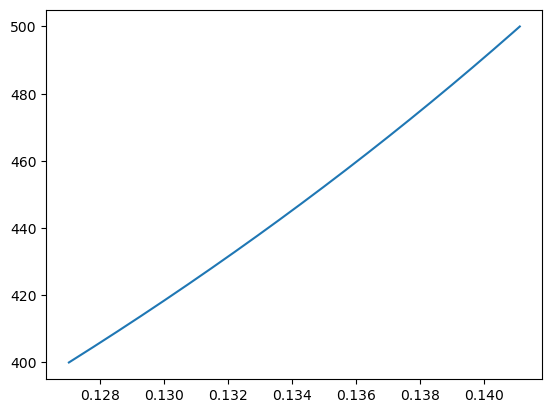

In [5]:
#Sol-Gel transition phase
θp=210
T = np.linspace(400, 500, num=500)
fig, ax=plt.subplots()
ax.plot([φ_cri(λ=λAS(J=(θp/t)), N=model.N) for t in T],T)
plt.show()
#np.save(f"gelation_θp_210_λ0_0.044.npy",[np.array([φ_cri(λ=λAS(J=(θp/t)), N=model.N) for t in T]),T])
#np.save(f"gelation_θp_210_λ0_0.503.npy",[np.array([φ_cri(J=(210/t)) for t in T]),T])

In [6]:
#The part is highly depend on which system I am interested in.
#The total free energy
def ftotal(**kwarg):
    return ( fp(φ=kwarg["φ"])
            +fw(φ0=1-kwarg["φ"])
            +fwp(χ=kwarg["χ"])(φ=kwarg["φ"], φ0=1-kwarg["φ"])
            +fdd(φ=kwarg["φ"],J=kwarg["J"])
            +fAS(φ=kwarg["φ"],λ=kwarg[ "λ"],gelstate=kwarg["gelstate"]) 
           )

#a=4*π*np.power(0.7,2)/18*4/9
#chi0=0.5+1/np.sqrt(model.N)+1/(2*model.N)
#chi=lambda T:a+chi0-3.3*a*300/T
χc=0.5+1/np.sqrt(model.N)+1/(2*model.N)
chi=lambda T:χc*280/T
θp=210

def ojective_saltfree(phase_vector,arg_vector):
    r,φ_one=phase_vector
    φ_exp,T, θp, gelstate= arg_vector
    φ_two=abs((φ_exp - r*φ_one)/(1-r))
    if 1>r>0 and 1>φ_one>0 and 1>φ_two>0 and φ_exp>=r*φ_one:    
        φ_two=(φ_exp - r*φ_one)/(1-r)
        value=(r* ftotal(φ=φ_one, χ=chi(T), J=(θp/T), λ=λAS(J=(θp/T)), gelstate=gelstate) 
               + (1-r) * ftotal(φ=φ_two, χ=chi(T), J=(θp/T), λ=λAS(J=(θp/T)), gelstate=gelstate)
              )
    else:
        value=np.inf
    return value    

In [17]:
#Spinodal Curve (Stockmayer)
gelstate="Stockmayer"
Phi =np.linspace(0.001, 0.3, num=100)#np.concatenate((np.linspace(0.001, 0.16, num=100), np.linspace(0.19, 0.25, num=100)), axis=0) 
T = np.linspace(273, 373, num=500)


Z=[[Dfφφ(ftotal,φ=x,χ=chi(y),J=(θp/y),λ=λAS(J=(θp/y)),gelstate=gelstate) for x in Phi] for y in T]
phi,t=np.meshgrid(Phi,T)
cs=plt.contour(phi, t, Z,[0],colors='red')

phi_s = cs.collections[0].get_paths()[0].vertices[:,0]
t_s = cs.collections[0].get_paths()[0].vertices[:,1]

#np.save(f"phi_t_Spinodal_θ_210_λ0_0.495_Stockmayer_branch_1.npy",[phi_s,t_s])
plt.close()

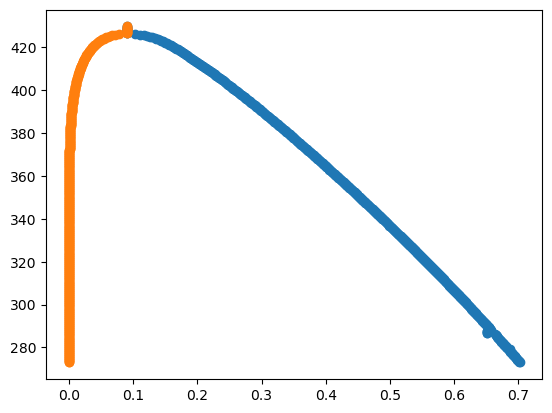

In [7]:
#Binodal Curve (Stockmayer)

#Using spinodal curve to narrow the range of binodal curve
#phi_s,t_s=np.load("phi_t_Spinodal_θ_210_λ0_0.377_Stockmayer.npy",allow_pickle=True)
#medium=(phi_s+phi_s[::-1])/2

gelstate="Stockmayer"
t_s=np.linspace(273, 430, num=500)
binodal=list([])
for i in range(0,np.argmax(t_s)):
        #phi_0=medium[i]
        phi_0=1/(np.sqrt(model.N)+1)
        T=t_s[i]
        res = minimize(ojective_saltfree, [0.3, 0.2],args=([phi_0,T,210,'Stockmayer']), method='nelder-mead',
                       options={'xatol': 1e-8, 'disp': False})
        if res.success == True:
            r=res.x[0]
            phi_one=res.x[1]
            phi_two=(phi_0 - r*phi_one)/(1-r)
            binodal.append([np.max([phi_one,phi_two]),np.min([phi_one,phi_two]),T])
#Inspection of data
plt.scatter(np.array(binodal)[:,0],np.array(binodal)[:,2])
plt.scatter(np.array(binodal)[:,1],np.array(binodal)[:,2])            
#np.save(f"rich_poor_t_Binodal_Tc_280_θp_210_λ0_0.044_Stockmayer.npy",
#[np.array(binodal)[:,0],np.array(binodal)[:,1],np.array(binodal)[:,2]]);             

In [8]:
#Spinodal Curve (Flory)
gelstate="Flory"
Phi =np.linspace(0.175, 0.3, num=100)
T = np.linspace(273, 373, num=500)

Z=[[Dfφφ(ftotal,φ=x,χ=chi(y),J=(θp/y),λ=λ(λ0=model.λ0, J=(θp/y)),gelstate=gelstate) for x in Phi] for y in T]
phi,t=np.meshgrid(Phi,T)
cs=plt.contour(phi, t, Z,[0],colors='red')

phi_s = cs.collections[0].get_paths()[0].vertices[:,0]
t_s = cs.collections[0].get_paths()[0].vertices[:,1]

#np.save(f"phi_t_Spinodal_θ_210_λ0_0.495_Stockmayer_branch_1.npy",[phi_s,t_s])
#plt.close()

TypeError: λ() got an unexpected keyword argument 'J'

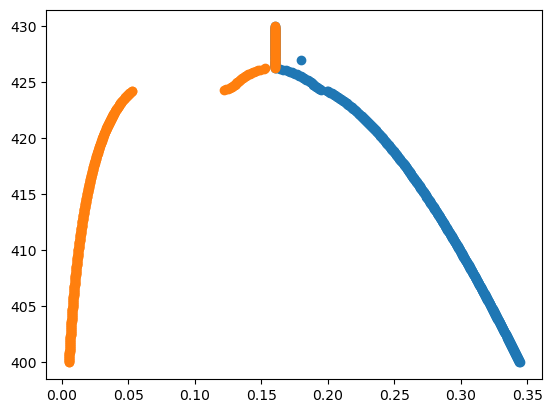

In [16]:
#Binodal Curve (Flory)

#Using spinodal curve to narrow the range of binodal curve
#phi_s,t_s=np.load("phi_t_Spinodal_θ_210_λ0_0.377_Stockmayer.npy",allow_pickle=True)
#medium=(phi_s+phi_s[::-1])/2

gelstate="Flory"
t_s=np.linspace(400, 430, num=500)
binodal=list([])
for i in range(0,np.argmax(t_s)):
        #phi_0=medium[i]
        #phi_0=1/(np.sqrt(model.N)+1)
        phi_0=0.16
        T=t_s[i]
        res = minimize(ojective_saltfree, [0.3, 0.2],args=([phi_0,T,210,'Flory']), method='nelder-mead',
                       options={'xatol': 1e-8, 'disp': False})
        if res.success == True:
            r=res.x[0]
            phi_one=res.x[1]
            phi_two=(phi_0 - r*phi_one)/(1-r)
            binodal.append([np.max([phi_one,phi_two]),np.min([phi_one,phi_two]),T])
#Inspection of data
plt.scatter(np.array(binodal)[:,0],np.array(binodal)[:,2])
plt.scatter(np.array(binodal)[:,1],np.array(binodal)[:,2])            
            
#np.save(f"rich_poor_t_Binodal_Tc_280_θp_210_λ0_0.377_Flory.npy",
#[np.array(binodal)[:,0],np.array(binodal)[:,1],np.array(binodal)[:,2]]);

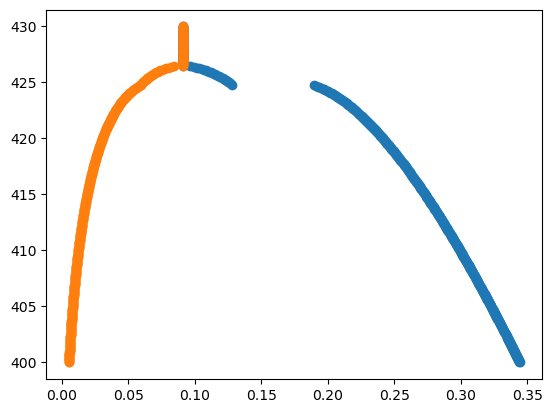

In [17]:
#Binodal Curve (Flory)

#Using spinodal curve to narrow the range of binodal curve
#phi_s,t_s=np.load("phi_t_Spinodal_θ_210_λ0_0.377_Stockmayer.npy",allow_pickle=True)
#medium=(phi_s+phi_s[::-1])/2

gelstate="Flory"
t_s=np.linspace(400, 430, num=500)
binodal=list([])
for i in range(0,np.argmax(t_s)):
        #phi_0=medium[i]
        phi_0=1/(np.sqrt(model.N)+1)
        #phi_0=0.18
        T=t_s[i]
        res = minimize(ojective_saltfree, [0.3, 0.2],args=([phi_0,T,210,'Flory']), method='nelder-mead',
                       options={'xatol': 1e-8, 'disp': False})
        if res.success == True:
            r=res.x[0]
            phi_one=res.x[1]
            phi_two=(phi_0 - r*phi_one)/(1-r)
            binodal.append([np.max([phi_one,phi_two]),np.min([phi_one,phi_two]),T])
#Inspection of data
plt.scatter(np.array(binodal)[:,0],np.array(binodal)[:,2])
plt.scatter(np.array(binodal)[:,1],np.array(binodal)[:,2])            
            
#np.save(f"rich_poor_t_Binodal_Tc_280_θp_210_λ0_0.377_Flory.npy",
#[np.array(binodal)[:,0],np.array(binodal)[:,1],np.array(binodal)[:,2]]);

In [84]:
np.save(f"rich_poor_t_Binodal_Tc_280_θp_210_λ0_0.048_Flory.npy",
[np.array(binodal)[:,0],np.array(binodal)[:,1],np.array(binodal)[:,2]]);

In [14]:
#Set the system in 300 k
model.T=300
model.lB=0.7*300/model.T
θp=210
fposion=fmolmix
fnegion=fmolmix
fif=fionfluctuation
fcd=fcharge_dipole(lB=model.lB)

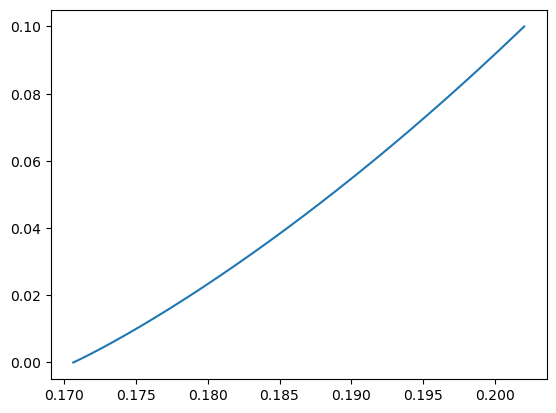

In [15]:
cion = np.linspace(0., 0.1, num=500)
fig, ax=plt.subplots()
ax.plot([φ_cri(λ=λAS(J=(θp/model.T),κ=κ(lB=model.lB)(ci)), N=model.N ) for ci in cion],cion)
plt.show()
#np.save(f"φ_ci_gelation_θ_210_λ0_0.377.npy",[np.array([φ_cri(J=(210/300),κ=κ(300,ci)) for ci in cion]),cion])

In [29]:
#The part is highly depend on which system I am interested in.
#The total free energy
def ftotal(**kwarg):
    return ( fp(φ=kwarg["φ"])
            +fw(φ0=1-kwarg["φ"])
            +fwp(χ=kwarg["χ"])(φ=kwarg["φ"], φ0=1-kwarg["φ"])
            +fdd(φ=kwarg["φ"],κ=κ(lB=model.lB)(kwarg["cion"]),J=kwarg["J"])
            +fAS(φ=kwarg["φ"],λ=kwarg[ "λ"],gelstate=kwarg["gelstate"]) 
            +fposion(φ0=kwarg["cion"]/2)
            +fnegion(φ0=kwarg["cion"]/2)
            +fif(κ=κ(lB=model.lB)(kwarg["cion"]))
            +fcd(cion=kwarg["cion"], φ=kwarg["φ"], J=kwarg[ "J"], κ=κ(lB=model.lB)(kwarg["cion"]))   )

a=4*π*np.power(0.7,2)/18*4/9
chi0=0.5+1/np.sqrt(model.N)+1/(2*model.N)

chi=lambda T:a+chi0-3.3*a*300/T
    
#Object function
def ojective(phase_vector,arg_vector):
    r, φ_one, ci_one=phase_vector
    φ_exp, ci_exp, Type = arg_vector
    χ=chi(model.T)
    J=θp/model.T
    φ_two=abs((φ_exp - r*φ_one)/(1-r))    
    if 1>r>0 and 1>φ_one>0 and 1>φ_two>0 and ci_one>=0 and φ_exp>=r*φ_one and ci_exp>=r*ci_one:
        φ_two=(φ_exp - r*φ_one)/(1-r)
        ci_two=(ci_exp - r*ci_one)/(1-r)
        value=(r* ftotal(φ=φ_one, χ=χ, J=J, λ=λAS(J=J, κ=κ(lB=model.lB)(ci_one)), gelstate=Type, cion=ci_one) 
               + (1-r) * ftotal(φ=φ_two, χ=χ, J=J, λ=λAS(J=J, κ=κ(lB=model.lB)(ci_one)), gelstate=Type, cion=ci_two)  )
    else:
        value=np.inf
    return value

#    r, φ, ci=phase_vector

In [44]:
cion=np.linspace(0.001, 0.0091, num=100)
binodal=list([])
for ci_0 in cion:
        phi_0=0.09
        res = minimize(ojective, [0.3, 0.20,0.01],args=([phi_0,ci_0,'Flory']), method='nelder-mead',
                       options={'xatol': 1e-8, 'disp': False})
        if res.success == True:
            r, phi_one, ci_one=res.x
            phi_two=(phi_0 - r*phi_one)/(1-r)
            ci_two=(ci_0 - r*ci_one)/(1-r)
            if phi_one>phi_two:
                binodal.append([[phi_one,ci_one],[phi_two,ci_two]])
            else:
                binodal.append([[phi_two,ci_two],[phi_one,ci_one]])

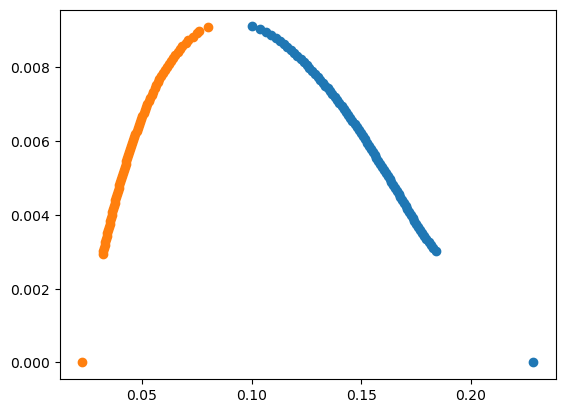

In [47]:
#Inspection data
phi_rich=np.array(binodal)[:,0,0]
phi_rich=np.insert(phi_rich, 0, 0.2282823261189555) #salt-free poit

c_rich=np.array(binodal)[:,0,1]
c_rich=np.insert(c_rich, 0, 0.)

phi_poor=np.array(binodal)[:,1,0]
phi_poor=np.insert(phi_poor, 0, 0.02268972048898255) #salt-free point

c_poor=np.array(binodal)[:,1,1]
c_poor=np.insert(c_poor, 0, 0.)

#plt.scatter(np.full(100, 0.1),cion)
plt.scatter(phi_rich,c_rich)
plt.scatter(phi_poor,c_poor)
plt.show()

#np.save(f"phi_rich_c_rich_phi_poor_c_poor_Binodal_θ_210_λ0_0.377_Flory.npy",[phi_rich,c_rich,phi_poor,c_poor])

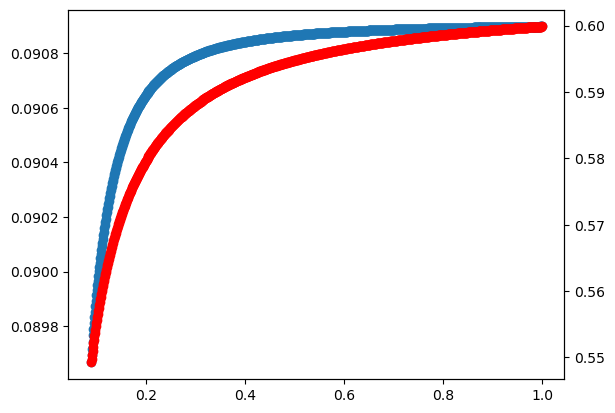

In [189]:
#Given a threshold concentration at Tc, the φc is
pc=1/(model.N-1)
φth_low=np.power(1+np.sqrt(model.N+3*(model.N**2)*(pc**2+pc**3/3)/(1+3*pc-pc*(pc+3))),-1)
Φth=np.arange(φth_low,1,0.001)
Φc=list([])
ΧASc=list([])
for φth in Φth:
    N=model.N
    def objectf(φc):
        α=p_sol(pc/(1-pc)**2*φc/φth,p_cri=pc)
        return φc-np.power(1+np.sqrt(N+3*(N**2)*(α**2+α**3/3)/(1+3*α-(α**2)*(α+3)/pc)),-1)
    sol=root_scalar(objectf,x0=0.01,x1=0.09)
    φc=sol.root
    Φc.append(φc)
    αprime=p_sol(pc/(1-pc)**2*φc/φth,p_cri=pc)
    mw=pc*(1+αprime)/(pc-αprime)
    ΧASc.append((1/(1-φc)+1/(N*φc*mw))/2)
#root_scalar(objectf,x0=xi,x1=xc)
fig, ax1 = plt.subplots()
ax2=ax1.twinx()
ax1.scatter(Φth,Φc)
ax2.scatter(Φth,χASc,c='red')

In [279]:
#Given a threshold concentration, φc and χASc are
φth=0.13
N=model.N
pc=1/(N-1)
def objectf(φc):
    α=p_sol(pc/(1-pc)**2*φc/φth,p_cri=pc)
    return φc-np.power(1+np.sqrt(N+3*(N**2)*(α**2+α**3/3)/(1+3*α-(α**2)*(α+3)/pc)),-1)
sol=root_scalar(objectf,x0=0.01,x1=0.09)
φc=sol.root
αprime=p_sol(pc/(1-pc)**2*φc/φth,p_cri=pc)
mw=pc*(1+αprime)/(pc-αprime)
χASc=(1/(1-φc)+1/(N*φc*mw))/2

In [280]:
#Import data
Δχ_x_g_h_cr_list=import_hdf5('Δχxghcr_phi_th_013.hdf5')

#To evaluate Tc


In [ ]:
p=1+1/(2*K_c)-np.sqrt(np.power(1+1/(2*K_c),2)-1)

In [248]:
print(Sflu(k=1,f=model.N,νf=1/2)(x=0.005*(1 - 0.005)**(100 - 2),g=1,h=1.1))
print(gf(0.01,model.N/(np.sqrt(model.N)+1),νfprime=1/2,fprime=model.N)(x=0.005*(1 - 0.005)**(100 - 2),g=1,h=1.1))
hf(0.01,model.N/(np.sqrt(model.N)+1),νfprime=1/2,fprime=model.N)(x=0.005*(1 - 0.005)**(100 - 2),g=1,h=1.1)

3.6316254694699605e-05
0.9840054680229002


1.0012489594022416

In [208]:
#Basic Input
print(model.λ0)
θp=210
TcAS=422.76  #An estimation
φth=φ_cri(λ=λAS(J=(θp/TcAS)), N=model.N) 
K=1/φth *(model.N - 1)/(model.N - 2)**2
φc=1/(np.sqrt(model.N)+1)
xc=(model.N-2)**(model.N-2)/(model.N-1)**(model.N-1)

0.048


In [218]:
#the Δχ
arr1=np.concatenate((np.array([1e-4,5e-4]), np.arange(1e-3,1e-2,0.001)), axis=0)
#Δχ=np.concatenate((arr1, np.arange(1e-2,6e-2,0.01)), axis=0)
Δχ=np.array([1e-2,5e-2])